In [43]:

import os
import gzip
import shutil
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAnnulus, CircularAperture, ApertureStats, aperture_photometry
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy import wcs
import pandas as pd

In [4]:
file_path = 'sims/run1/r/lsst_e_0280_f3_R22_S11_E000.fits.gz'
image1 = fits.open(file_path)
image1.info()
image1[0].header



Filename: sims/run1/r/lsst_e_0280_f3_R22_S11_E000.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     675   (4004, 4096)   float32   


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4004 / length of data axis 1                          
NAXIS2  =                 4096 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CTYPE1  = 'RA---TAN'                                                            
CRPIX1  =                2002.                                                  
CRVAL1  =                150.1                                                  
CTYPE2  = 'DEC--TAN'                                                            
CRPIX2  =                204

In [10]:
print('filter type:', image1[0].header['FILTER'])
print('exposure time:', image1[0].header['EXPTIME'])
cdelt1 = image1[0].header['CD1_1']
cdelt2 = image1[0].header['CD1_2']
# Calculate the image scale (arcsec/pixel)
image_scale = abs(cdelt2)  # Assuming CDELT1 is in arcseconds/pixel

# Example: Convert arcseconds to pixels
arcseconds = 0.5
pixel_size = arcseconds / image_scale
print(f"The image scale is {image_scale} arcsec/pixel")
print(f"{arcseconds} arcseconds corresponds to {pixel_size} pixels")

imagedata = image1[0].data
mean, median, std = sigma_clipped_stats(imagedata, sigma=5.0)
print(f"Mean: {mean:.2f}, Median: {median:.2f}, Std: {std:.2f}")


daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(imagedata - median)
if sources is not None:
    for col in sources.colnames:
        if col not in ('id', 'npix'):
            sources[col].info.format = '%.2f'  # for consistent table output
    sources.pprint(max_width=76)
else:
    print("No sources found.")

filter type: (
exposure time: 30.0
The image scale is 2.52072361104494e-05 arcsec/pixel
0.5 arcseconds corresponds to 19835.574110908976 pixels
Mean: 398.61, Median: 411.00, Std: 47.90
 id xcentroid ycentroid sharpness roundness1 ... sky    peak   flux  mag 
--- --------- --------- --------- ---------- ... ---- ------- ----- -----
  1   3186.25    204.59      0.77      -0.55 ... 0.00 1997.00  6.87 -2.09
  2   2157.81    270.62      0.97       0.10 ... 0.00 5855.00 16.59 -3.05
  3   3245.19    301.06      0.70       0.92 ... 0.00 3296.00 11.56 -2.66
  4    656.03    343.38      0.82      -0.49 ... 0.00 1018.00  3.27 -1.29
  5    650.18    355.45      0.76      -0.36 ... 0.00  810.00  2.65 -1.06
  6   3324.40    459.58      0.70       0.65 ... 0.00 5617.00 20.87 -3.30
  7    878.83    526.51      0.81      -0.03 ... 0.00 3077.00 10.77 -2.58
  8   3233.97    695.69      0.74      -0.95 ... 0.00 4682.00 16.41 -3.04
  9     81.91    892.88      0.97      -0.03 ... 0.00 5059.00 15.97 -3.01
 

In [ ]:
# Load the WCS information from a fits header, and use it
# to convert pixel coordinates to world coordinates.

import sys

import numpy as np

from astropy import wcs
from astropy.io import fits


def load_wcs_from_file(filename):
    # Load the FITS hdulist using astropy.io.fits
    hdulist = fits.open(filename)

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[0].header)

    # Print out the "name" of the WCS, as defined in the FITS header
    print(w.wcs.name)

    # Print out all of the settings that were parsed from the header
    w.wcs.print_contents()

    # Three pixel coordinates of interest.
    # Note we've silently assumed an NAXIS=2 image here.
    # The pixel coordinates are pairs of [X, Y].
    # The "origin" argument indicates whether the input coordinates
    # are 0-based (as in Numpy arrays) or
    # 1-based (as in the FITS convention, for example coordinates
    # coming from DS9).
    pixcrd = np.array([[0, 0], [24, 38], [45, 98]], dtype=np.float64)

    # Convert pixel coordinates to world coordinates
    # The second argument is "origin" -- in this case we're declaring we
    # have 0-based (Numpy-like) coordinates.
    world = w.wcs_pix2world(pixcrd, 0)
    print(world)

    # Convert the same coordinates back to pixel coordinates.
    pixcrd2 = w.wcs_world2pix(world, 0)
    print(pixcrd2)

    # These should be the same as the original pixel coordinates, modulo
    # some floating-point error.
    assert np.max(np.abs(pixcrd - pixcrd2)) < 1e-6

    # The example below illustrates the use of "origin" to convert between
    # 0- and 1- based coordinates when executing the forward and backward
    # WCS transform.
    x = 0
    y = 0
    origin = 0
    assert w.wcs_pix2world(x, y, origin) == w.wcs_pix2world(x + 1, y + 1, origin + 1)


file_path = 'sims/run1/r/lsst_e_0020_f3_R22_S11_E000.fits.gz'
load_wcs_from_file(file_path)

# Load the WCS information from a fits header, and use it
# to convert pixel coordinates to world coordinat

# Image plotter

Mean: 1989.47, Median: 1989.00, Std: 44.74
 id     xcentroid          ycentroid          sharpness       roundness1        roundness2       npix sky   peak         flux                mag        
--- ------------------ ------------------ ------------------ ------------ ---------------------- ---- --- ------- ------------------ -------------------
  1   663.114944888191  347.6974752441622 0.5942009671614361  -0.07066627  -0.012245960766428404  169 0.0 16354.0 189.15419006347656   -5.69203991510669
  2   594.936893291824  514.0212420222048 0.6285342089224523  -0.05542708   -0.01924175320810053  169 0.0  6847.0  76.45487976074219  -4.708513024093897
  3  761.3910360830939   582.183555425277 0.5891163068080244 -0.030505722   -0.03468050785117852  169 0.0 14178.0 164.74058532714844  -5.542001511772118
  4  526.7883667668094  680.3199904262916 0.5950553260911495  -0.08016493  -0.014467449513977534  169 0.0  2604.0 30.060564041137695  -3.694992813020396
  5  693.2083854689704  748.52653906563

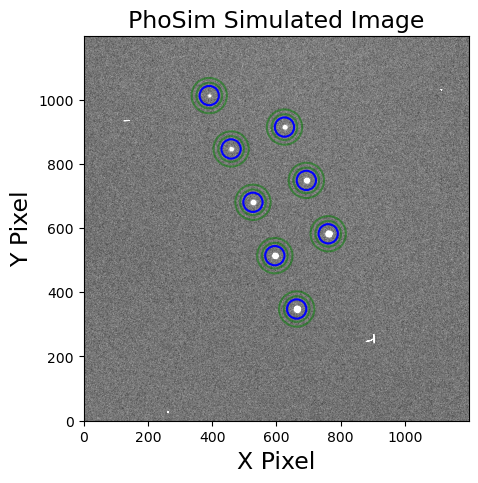

Mean: 273.31, Median: 273.00, Std: 16.56
 id     xcentroid         ycentroid          sharpness        roundness1       roundness2      npix sky   peak         flux                mag        
--- ----------------- ------------------ ------------------ ------------- -------------------- ---- --- ------- ------------------ -------------------
  1  435.858319073699 438.74937999523615 0.7111064856540585   -0.08813969   0.0471520501987404  169 0.0   360.0 10.265158653259277 -2.5284141650026637
  2 600.4697201168627 510.82305325731886 0.7292997520786668  -0.061272256 0.004054283345713466  169 0.0   886.0 24.770891189575195 -3.4848540790153044
  3 765.1623174103419   582.900450270391 0.7374280426517164  -0.042808786  0.03289849890302994  169 0.0  2265.0 63.092491149902344  -4.499944188672556
  4 929.8757295899272  654.9839808567752  0.723408245655399  -0.016547589 0.029927512502977795  169 0.0  5663.0 160.19204711914062  -5.511602378340478
  5 528.3241509353516  675.6391575478906 0.6913629416

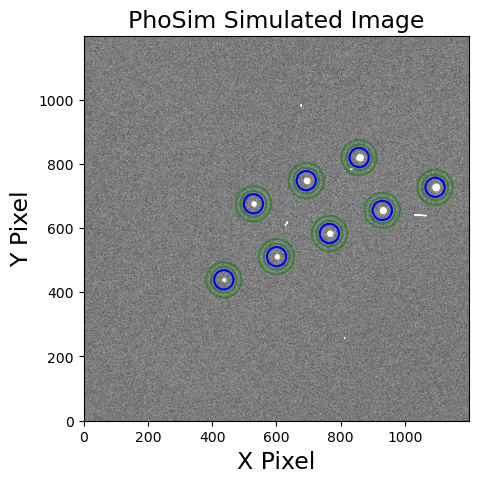

In [47]:
from astropy.visualization import ZScaleInterval, ImageNormalize

def stars_finder(data, fwhm=20.0, threshold=5.0, print_stats=True):
    mean, median, std = sigma_clipped_stats(data, sigma=5.0)
    bkg_stat = [mean, median, std]
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold*std)
    sources = daofind(data - median)
    if print_stats == True:
        print(f"Mean: {mean:.2f}, Median: {median:.2f}, Std: {std:.2f}")
        sources.pprint_all()

    return bkg_stat, sources

def sources_phot(data, positions, r_apt = 25, r_in = 40, r_out = 55, print_stats=True):
    apertures = CircularAperture(positions, r=r_apt)
    annulus_aperture = CircularAnnulus(positions, r_in=r_in, r_out=r_out)
    apertures.plot(color='blue', lw=1.5, alpha=1)
    annulus_aperture.plot(color='green',lw=1.5,alpha=0.5)

    aperstats = ApertureStats(data, annulus_aperture)
    bkg_mean = aperstats.mean
    aperture_area = apertures.area_overlap(data)
    total_bkg = bkg_mean * aperture_area
    error = 0.1 * data
    phot_table = aperture_photometry(data, apertures, error=error)
    phot_bkgsub = phot_table['aperture_sum'] - total_bkg
    phot_table['total_bkg'] = total_bkg
    phot_table['aperture_sum_bkgsub'] = phot_bkgsub
    if print_stats == True:
        phot_table.pprint_all()
    return phot_table

    #return phot_table

def image_checker(fits_file, fwhm=10.0, threshold=5.0, r_apt=30, r_in=40, r_out=55):
    with fits.open(fits_file) as hdul:
        data = hdul[0].data[1300:2500,1300:2500]
        w = wcs.WCS(hdul[0].header)

        # Normalize the image using ZScaleInterval
        norm = ImageNormalize(data, interval=ZScaleInterval())
        bkg_stat, sources = stars_finder(data, fwhm, threshold, print_stats=True)
        positions = (np.transpose((sources['xcentroid'], sources['ycentroid'])))

        world = w.wcs_pix2world(positions, 0)
        
        plt.figure(figsize=(5, 5))
        phot_table = sources_phot(data, positions, r_apt, r_in, r_out, print_stats=True)
        print(world)
        plt.imshow(data, cmap='gray', origin='lower', norm=norm)
        #plt.colorbar(fontsize=17)
        #plt.title(f'FITS Image: {fits_file}', fontsize=17)
        plt.title('PhoSim Simulated Image', fontsize=17)
        plt.xlabel('X Pixel', fontsize=17)
        plt.ylabel('Y Pixel' , fontsize=17)
        plt.show()

file_path = 'sims/run1/r/lsst_e_0002_f3_R22_S11_E000.fits.gz'
image_checker(file_path)
image_checker('sims/run1/r/lsst_e_0300_f3_R22_S11_E000.fits.gz')

In [ ]:
# Directory containing the subfolders with .gz files
directory = 'sims/run1/r'

# Iterate over each subdirectory in the directory
for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    #print(subdir_path)
    if os.path.isdir(subdir_path):
        # Iterate over each file in the subdirectory
        for filename in os.listdir(subdir_path):
            print(filename)
            if filename.endswith('.gz'):
                # Unzip the file
                gz_path = os.path.join(subdir_path, filename)
                fits_path = os.path.join(subdir_path, filename[:-3])  # Remove the .gz extension
                
                with gzip.open(gz_path, 'rb') as f_in:
                    with open(fits_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)

                        
                

# Unzipper

In [ ]:
import os
import gzip
import shutil

def unzip_gz_files(directory):
    # Iterate over each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.gz'):
            # Unzip the file
            gz_path = os.path.join(directory, filename)
            fits_path = os.path.join(directory, filename[:-3])  # Remove the .gz extension
            
            with gzip.open(gz_path, 'rb') as f_in:
                with open(fits_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            print(f"Unzipped: {filename}")
# Example usage
directory = 'sims/run1/u'
unzip_gz_files(directory)

Unzipped: lsst_e_0000_f0_R22_S11_E000.fits.gz
Time: 60746.9998263889, Filter: 0
Unzipped: lsst_e_0001_f0_R22_S11_E000.fits.gz
Time: 60748.9998263889, Filter: 0
Unzipped: lsst_e_0002_f0_R22_S11_E000.fits.gz
Time: 60750.9998263889, Filter: 0
Unzipped: lsst_e_0003_f0_R22_S11_E000.fits.gz
Time: 60752.9998263889, Filter: 0
Unzipped: lsst_e_0004_f0_R22_S11_E000.fits.gz
Time: 60754.9998263889, Filter: 0
Unzipped: lsst_e_0005_f0_R22_S11_E000.fits.gz
Time: 60756.9998263889, Filter: 0
Unzipped: lsst_e_0006_f0_R22_S11_E000.fits.gz
Time: 60758.9998263889, Filter: 0
Unzipped: lsst_e_0007_f0_R22_S11_E000.fits.gz
Time: 60760.9998263889, Filter: 0
Unzipped: lsst_e_0008_f0_R22_S11_E000.fits.gz
Time: 60762.9998263889, Filter: 0
Unzipped: lsst_e_0009_f0_R22_S11_E000.fits.gz
Time: 60764.9998263889, Filter: 0
Unzipped: lsst_e_0010_f0_R22_S11_E000.fits.gz
Time: 60766.9998263889, Filter: 0
Unzipped: lsst_e_0011_f0_R22_S11_E000.fits.gz
Time: 60768.9998263889, Filter: 0
Unzipped: lsst_e_0012_f0_R22_S11_E000.fi

# Date extractor

In [21]:
time_u = []
time_g = []
time_r = []
time_i = []
time_z = []
time_y = []

def date_extract(directory, time_array):
    # Iterate over each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.gz'):
            # Unzip the file
            #gz_path = os.path.join(directory, filename)
            #fits_path = os.path.join(directory, filename[:-3])  # Remove the .gz extension
            
            #with gzip.open(gz_path, 'rb') as f_in:
            #    with open(fits_path, 'wb') as f_out:
            #        shutil.copyfileobj(f_in, f_out)
            #print(f"Unzipped: {filename}")
            file_path = os.path.join(directory, filename)
            # Extract the time from the filename
            image1 = fits.open(file_path)
            time = image1[0].header['MJD-OBS']
            filter_type = image1[0].header['FILTNM']
            print(f"Time: {time}, Filter: {filter_type}")
            time_array.append(time)
            image1.close()


# Example usage
directory = 'sims/run1/u'
date_extract(directory,time_u)


Time: 60746.9998263889, Filter: 0
Time: 60748.9998263889, Filter: 0
Time: 60750.9998263889, Filter: 0
Time: 60752.9998263889, Filter: 0
Time: 60754.9998263889, Filter: 0
Time: 60756.9998263889, Filter: 0
Time: 60758.9998263889, Filter: 0
Time: 60760.9998263889, Filter: 0
Time: 60762.9998263889, Filter: 0
Time: 60764.9998263889, Filter: 0
Time: 60766.9998263889, Filter: 0
Time: 60768.9998263889, Filter: 0
Time: 60770.9998263889, Filter: 0
Time: 60772.9998263889, Filter: 0
Time: 60774.9998263889, Filter: 0
Time: 60776.9998263889, Filter: 0
Time: 60778.9998263889, Filter: 0
Time: 60780.9998263889, Filter: 0
Time: 60782.9998263889, Filter: 0
Time: 60784.9998263889, Filter: 0
Time: 60786.9998263889, Filter: 0
Time: 60788.9998263889, Filter: 0
Time: 60790.9998263889, Filter: 0
Time: 60792.9998263889, Filter: 0
Time: 60794.9998263889, Filter: 0
Time: 60796.9998263889, Filter: 0
Time: 60798.9998263889, Filter: 0
Time: 60800.9998263889, Filter: 0
Time: 60802.9998263889, Filter: 0
Time: 60804.99

In [22]:
print(f"Time U: {time_u}")

Time U: [60746.9998263889, 60748.9998263889, 60750.9998263889, 60752.9998263889, 60754.9998263889, 60756.9998263889, 60758.9998263889, 60760.9998263889, 60762.9998263889, 60764.9998263889, 60766.9998263889, 60768.9998263889, 60770.9998263889, 60772.9998263889, 60774.9998263889, 60776.9998263889, 60778.9998263889, 60780.9998263889, 60782.9998263889, 60784.9998263889, 60786.9998263889, 60788.9998263889, 60790.9998263889, 60792.9998263889, 60794.9998263889, 60796.9998263889, 60798.9998263889, 60800.9998263889, 60802.9998263889, 60804.9998263889, 60806.9998263889, 60808.9998263889, 60810.9998263889, 60812.9998263889, 60814.9998263889, 60816.9998263889, 60818.9998263889, 60820.9998263889, 60822.9998263889, 60824.9998263889, 60826.9998263889, 60828.9998263889, 60830.9998263889, 60832.9998263889, 60834.9998263889, 60836.9998263889, 60838.9998263889, 60840.9998263889, 60842.9998263889, 60844.9998263889, 60846.9998263889, 60848.9998263889, 60850.9998263889, 79308.2596423889, 79308.2636693889, 7

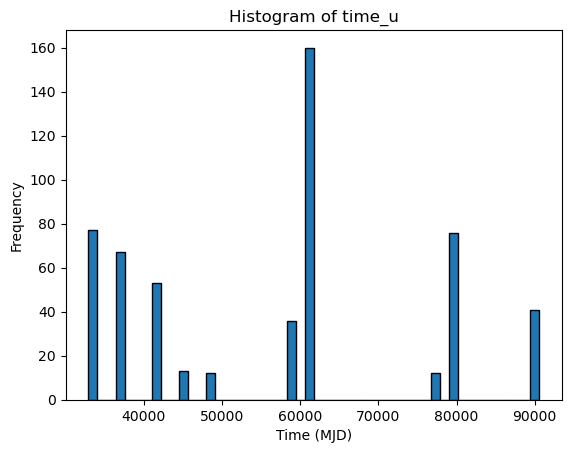

In [23]:
plt.hist(time_u, bins=50, edgecolor='black')
plt.xlabel('Time (MJD)')
plt.ylabel('Frequency')
plt.title('Histogram of time_u')
plt.show()

In [12]:
directory = 'sims/run1/r'
unzip_gz_files(directory)

Time: 60746.9998263889, Filter: 3
Time: 60748.9998263889, Filter: 3
Time: 60750.9998263889, Filter: 3
Time: 60752.9998263889, Filter: 3
Time: 60754.9998263889, Filter: 3
Time: 60756.9998263889, Filter: 3
Time: 60758.9998263889, Filter: 3
Time: 60760.9998263889, Filter: 3
Time: 60762.9998263889, Filter: 3
Time: 60764.9998263889, Filter: 3
Time: 60766.9998263889, Filter: 3
Time: 60768.9998263889, Filter: 3
Time: 60770.9998263889, Filter: 3
Time: 60772.9998263889, Filter: 3
Time: 60774.9998263889, Filter: 3
Time: 60776.9998263889, Filter: 3
Time: 60778.9998263889, Filter: 3
Time: 60780.9998263889, Filter: 3
Time: 60782.9998263889, Filter: 3
Time: 60784.9998263889, Filter: 3
Time: 60786.9998263889, Filter: 3
Time: 60788.9998263889, Filter: 3
Time: 60790.9998263889, Filter: 3
Time: 60792.9998263889, Filter: 3
Time: 60794.9998263889, Filter: 3
Time: 60796.9998263889, Filter: 3
Time: 60798.9998263889, Filter: 3
Time: 60800.9998263889, Filter: 3
Time: 60802.9998263889, Filter: 3
Time: 60804.99

In [11]:
# Directory containing the .fits files
directory = 'sims/run1/r/'
index = 0
# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.fits'):
        # Define the new filename
        new_filename = "run1_r_$" + str(index) + '.fits'
        index += 1
        # Get the full path of the old and new filenames
        old_file_path = os.path.join(directory, filename)
        new_file_path = os.path.join(directory, new_filename)
        
        # Rename the file
        os.rename(old_file_path, new_file_path)
        print(f"Renamed: {filename} to {new_filename}")

Renamed: lsst_e_0000_f3_R22_S11_E000.fits to run1_r_$0.fits
Renamed: lsst_e_0001_f3_R22_S11_E000.fits to run1_r_$1.fits
Renamed: lsst_e_0002_f3_R22_S11_E000.fits to run1_r_$2.fits
Renamed: lsst_e_0003_f3_R22_S11_E000.fits to run1_r_$3.fits
Renamed: lsst_e_0004_f3_R22_S11_E000.fits to run1_r_$4.fits
Renamed: lsst_e_0005_f3_R22_S11_E000.fits to run1_r_$5.fits
Renamed: lsst_e_0006_f3_R22_S11_E000.fits to run1_r_$6.fits
Renamed: lsst_e_0007_f3_R22_S11_E000.fits to run1_r_$7.fits
Renamed: lsst_e_0008_f3_R22_S11_E000.fits to run1_r_$8.fits
Renamed: lsst_e_0009_f3_R22_S11_E000.fits to run1_r_$9.fits
Renamed: lsst_e_0010_f3_R22_S11_E000.fits to run1_r_$10.fits
Renamed: lsst_e_0011_f3_R22_S11_E000.fits to run1_r_$11.fits
Renamed: lsst_e_0012_f3_R22_S11_E000.fits to run1_r_$12.fits
Renamed: lsst_e_0013_f3_R22_S11_E000.fits to run1_r_$13.fits
Renamed: lsst_e_0014_f3_R22_S11_E000.fits to run1_r_$14.fits
Renamed: lsst_e_0015_f3_R22_S11_E000.fits to run1_r_$15.fits
Renamed: lsst_e_0016_f3_R22_S11_E0

# WCS Header reader

In [2]:
# Load the WCS information from a fits header, and use it
# to convert pixel coordinates to world coordinates.

import sys

import numpy as np

from astropy import wcs
from astropy.io import fits


def load_wcs_from_file(filename):
    # Load the FITS hdulist using astropy.io.fits
    hdulist = fits.open(filename)

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[0].header)

    # Print out the "name" of the WCS, as defined in the FITS header
    print(w.wcs.name)

    # Print out all of the settings that were parsed from the header
    w.wcs.print_contents()

    # Three pixel coordinates of interest.
    # Note we've silently assumed an NAXIS=2 image here.
    # The pixel coordinates are pairs of [X, Y].
    # The "origin" argument indicates whether the input coordinates
    # are 0-based (as in Numpy arrays) or
    # 1-based (as in the FITS convention, for example coordinates
    # coming from DS9).
    pixcrd = np.array([[0, 0], [24, 38], [45, 98]], dtype=np.float64)

    # Convert pixel coordinates to world coordinates
    # The second argument is "origin" -- in this case we're declaring we
    # have 0-based (Numpy-like) coordinates.
    world = w.wcs_pix2world(pixcrd, 0)
    print(world)

    # Convert the same coordinates back to pixel coordinates.
    pixcrd2 = w.wcs_world2pix(world, 0)
    print(pixcrd2)

    # These should be the same as the original pixel coordinates, modulo
    # some floating-point error.
    assert np.max(np.abs(pixcrd - pixcrd2)) < 1e-6

    # The example below illustrates the use of "origin" to convert between
    # 0- and 1- based coordinates when executing the forward and backward
    # WCS transform.
    x = 0
    y = 0
    origin = 0
    assert w.wcs_pix2world(x, y, origin) == w.wcs_pix2world(x + 1, y + 1, origin + 1)


file_path = 'sims/run1/r/lsst_e_0020_f3_R22_S11_E000.fits.gz'
load_wcs_from_file(file_path)

# Load the WCS information from a fits header, and use it
# to convert pixel coordinates to world coordinat


[[150.12687222   2.33869109]
 [150.12697478   2.3361963 ]
 [150.12790969   2.3327905 ]]
[[-4.43378667e-11 -3.73574949e-10]
 [ 2.40000000e+01  3.80000000e+01]
 [ 4.50000000e+01  9.80000000e+01]]


# Read CSV

In [3]:
# Read in the data from the CSV files
r_band_data = pd.read_csv('sims/run1/r_band.csv')
u_band_data = pd.read_csv('sims/run1/u_band.csv')
y_band_data = pd.read_csv('sims/run1/y_band.csv')

# Extract the flux readings into arrays
r_band_flux_z05 = r_band_data['rel_flux_T1'].values
u_band_flux_z05 = u_band_data['rel_flux_T1'].values
y_band_flux_z05 = y_band_data['rel_flux_T1'].values
r_band_flux_z05_err = abs(r_band_data['rel_flux_err_T1'].values)
u_band_flux_z05_err = abs(u_band_data['rel_flux_err_T1'].values)
y_band_flux_z05_err = abs(y_band_data['rel_flux_err_T1'].values)

r_band_flux_z1 = r_band_data['rel_flux_T3'].values
u_band_flux_z1 = u_band_data['rel_flux_T7'].values
y_band_flux_z1 = y_band_data['rel_flux_T3'].values
r_band_flux_z1_err = abs(r_band_data['rel_flux_err_T3'].values)
u_band_flux_z1_err = abs(u_band_data['rel_flux_err_T7'].values)
y_band_flux_z1_err = abs(y_band_data['rel_flux_err_T3'].values)


r_band_flux_z2 = r_band_data['rel_flux_T4'].values
u_band_flux_z2 = u_band_data['rel_flux_T8'].values
y_band_flux_z2 = y_band_data['rel_flux_T4'].values
r_band_flux_z2_err = abs(r_band_data['rel_flux_err_T4'].values)
u_band_flux_z2_err = abs(u_band_data['rel_flux_err_T8'].values)
y_band_flux_z2_err = abs(y_band_data['rel_flux_err_T4'].values)

In [4]:
u_band_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Columns: 204 entries, Label to N_Sky_Pixels_T8
dtypes: float64(181), int64(22), object(1)
memory usage: 871.9+ KB


In [5]:
# Extract the 4-digit number from the 'label' column
r_band_data['label_number'] = r_band_data['Label'].str.extract(r'(\d{4})')
u_band_data['label_number'] = u_band_data['Label'].str.extract(r'(\d{4})')
y_band_data['label_number'] = y_band_data['Label'].str.extract(r'(\d{4})')

print("R band label numbers:", r_band_data['label_number'])
print("U band label numbers:", u_band_data['label_number'])
print("Y band label numbers:", y_band_data['label_number'])

R band label numbers: 0      0000
1      0001
2      0002
3      0003
4      0004
       ... 
495    0541
496    0542
497    0544
498    0545
499    0546
Name: label_number, Length: 500, dtype: object
U band label numbers: 0      0000
1      0001
2      0002
3      0003
4      0004
       ... 
542    0542
543    0543
544    0544
545    0545
546    0546
Name: label_number, Length: 547, dtype: object
Y band label numbers: 0      0000
1      0001
2      0002
3      0003
4      0004
       ... 
170    0170
171    0171
172    0172
173    0173
174    0174
Name: label_number, Length: 175, dtype: object


In [6]:
# Convert the number strings to integers and multiply by 2
u_band_data['label_number'] = u_band_data['label_number'].astype(int) * 2
r_band_data['label_number'] = r_band_data['label_number'].astype(int) * 2
y_band_data['label_number'] = y_band_data['label_number'].astype(int) * 2


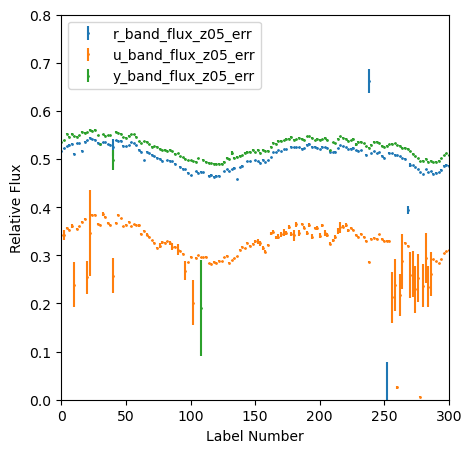

In [7]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
#ax.scatter(r_band_data['label_number'], r_band_flux_z05, s=0.5, label='r_band_flux_z05', marker='o')
#ax.scatter(u_band_data['label_number'], u_band_flux_z05, s=0.5, label='u_band_flux_z05', marker='o')
#ax.scatter(y_band_data['label_number'], y_band_flux_z05, s=0.5, label='y_band_flux_z05', marker='o')
ax.errorbar(r_band_data['label_number'], r_band_flux_z05, yerr=r_band_flux_z05_err, fmt='o', markersize=1, label='r_band_flux_z05_err')
ax.errorbar(u_band_data['label_number'], u_band_flux_z05, yerr=u_band_flux_z05_err, fmt='o', markersize=1, label='u_band_flux_z05_err')
ax.errorbar(y_band_data['label_number'], y_band_flux_z05, yerr=y_band_flux_z05_err, fmt='o', markersize=1, label='y_band_flux_z05_err')
ax.set_xlabel('Label Number')
ax.set_ylabel('Relative Flux')
ax.set_ylim(0, 0.8)
ax.set_xlim(0, 300)
ax.legend()


ValueError: 'yerr' (shape: (174,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (170,))

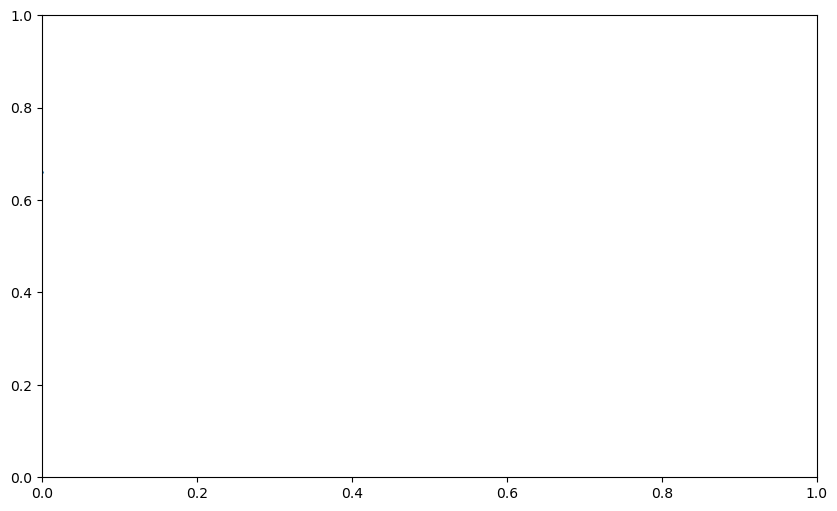

In [ ]:
from scipy.stats import zscore

# Function to remove outliers based on z-score
def remove_outliers(data, threshold=3):
    z_scores = zscore(data)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < threshold)
    return filtered_entries

# Remove outliers from the flux data
start_day = 0
end_day = 170
filtered_y_indices_z05 = remove_outliers(y_band_flux_z05)
filtered_u_indices_z05 = remove_outliers(u_band_flux_z05)
filtered_r_indices_z05 = remove_outliers(r_band_flux_z05)

#filtered_indices_z1 = remove_outliers(y_band_flux_z1)
#filtered_indices_z2 = remove_outliers(y_band_flux_z2)

# Apply the filter to the data
y_band_flux_z05_filtered = y_band_flux_z05[filtered_y_indices_z05]
y_band_flux_z05_err_filtered = y_band_flux_z05_err[filtered_y_indices_z05]
y_days_filtered = y_band_data['label_number'][filtered_y_indices_z05]
u_band_flux_z05_filtered = u_band_flux_z05[filtered_u_indices_z05]
u_band_flux_z05_err_filtered = u_band_flux_z05_err[filtered_u_indices_z05]
u_days_filtered = u_band_data['label_number'][filtered_u_indices_z05]
r_band_flux_z05_filtered = r_band_flux_z05[filtered_r_indices_z05]
r_band_flux_z05_err_filtered = r_band_flux_z05_err[filtered_r_indices_z05]
r_days_filtered = r_band_data['label_number'][filtered_r_indices_z05]


# Normalize the filtered flux data
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def err_normalize(data):
    return data / (np.max(data) - np.min(data))

normalized_y_flux_z05 = normalize(y_band_flux_z05_filtered[start_day:end_day])
normalized_u_flux_z05 = normalize(u_band_flux_z05_filtered[start_day:end_day])
normalized_r_flux_z05 = normalize(r_band_flux_z05_filtered[start_day:end_day])
normalized_y_flux_z05_err = err_normalize(y_band_flux_z05_err_filtered[start_day:end_day])
normalized_u_flux_z05_err = err_normalize(u_band_flux_z05_err_filtered[start_day:end_day])
normalized_r_flux_z05_err = err_normalize(r_band_flux_z05_err_filtered[start_day:end_day])
#print(len(u_days_filtered), len(normalized_u_flux_z05), len(normalized_u_flux_z05_err))
# Plot the normalized light curves
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.errorbar(y_days_filtered[start_day:end_day], normalized_y_flux_z05, yerr=normalized_y_flux_z05_err, fmt='o', markersize=1, label='y')
ax.errorbar(u_days_filtered[start_day:end_day], normalized_u_flux_z05, yerr=normalized_u_flux_z05_err, fmt='o', markersize=1, label='u')
ax.errorbar(r_days_filtered[start_day:end_day], normalized_r_flux_z05, yerr=normalized_r_flux_z05_err, fmt='o', markersize=1, label='r')
ax.set_xlabel('days')
ax.set_ylabel('Normalized Flux')
ax.legend()
ax.set_xlim(0, 300)
plt.show()

(0.0, 300.0)

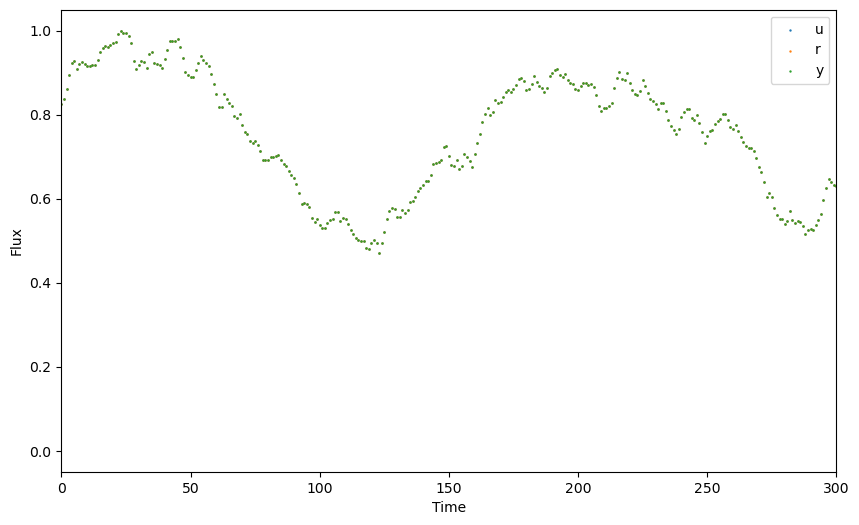

In [42]:
# Read in the data from the CSV files
data_2433 = pd.read_csv('Data/Fiducial/z05/2433_scaled_light_curve.csv')
data_4387 = pd.read_csv('Data/Fiducial/z05/4387_scaled_light_curve.csv')
data_6800 = pd.read_csv('Data/Fiducial/z05/6800_scaled_light_curve.csv')

u_flux = data_2433['flux [mJy]']
r_flux = data_4387['flux [mJy]']
y_flux = data_6800['flux [mJy]']

# Function to normalize data
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

normalized_model_flux_u = normalize(data_2433['flux [mJy]'])
normalized_model_flux_r = normalize(data_4387['flux [mJy]'])
normalized_model_flux_y = normalize(data_6800['flux [mJy]'])

# Plot the flux against time for each dataset
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.scatter(data_2433['time'], normalized_model_flux_u, s=0.5, label='u')
ax.scatter(data_4387['time'], normalized_model_flux_r, s=0.5, label='r')
ax.scatter(data_6800['time'], normalized_model_flux_y, s=0.5, label='y')
ax.set_xlabel('Time')
ax.set_ylabel('Flux')
ax.legend()
ax.set_xlim(0, 300)

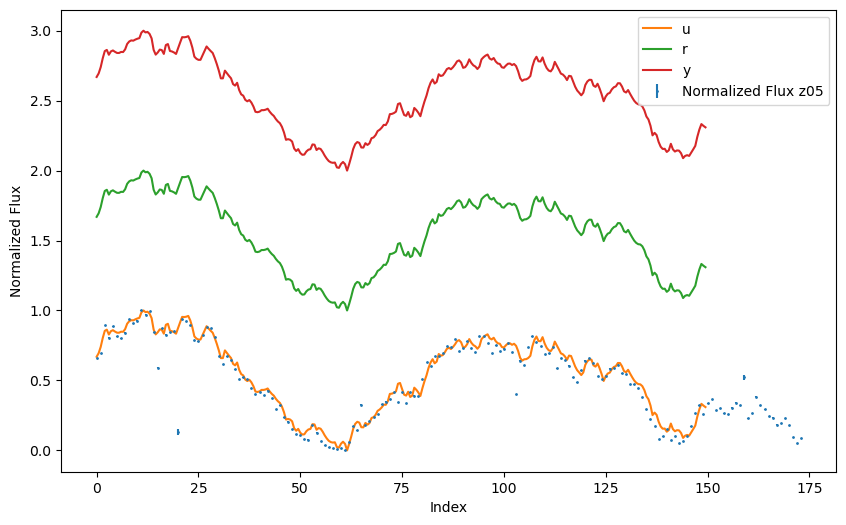

In [38]:
# Function to normalize data
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
end = 300
normalized_model_flux_u = normalize(data_2433['flux [mJy]'][:end])
normalized_model_flux_r = normalize(data_4387['flux [mJy]'][:end])
normalized_model_flux_y = normalize(data_6800['flux [mJy]'][:end])

# Plot the normalized data
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.errorbar(range(len(normalized_flux_z05)), normalized_flux_z05, yerr=y_band_flux_z05_err_filtered, fmt='o', markersize=1, label='Normalized Flux z05')
##ax.errorbar(range(len(normalized_flux_z2)), normalized_flux_z2, yerr=y_band_flux_z2_err_filtered, fmt='o', markersize=1, label='Normalized Flux z2')
ax.plot(data_2433['time'][:end]/2,normalized_model_flux_u, label='u')
ax.plot(data_4387['time'][:end]/2,normalized_model_flux_r+1, label='r')
ax.plot(data_6800['time'][:end]/2,normalized_model_flux_y+2, label='y')
ax.set_xlabel('Index')
ax.set_ylabel('Normalized Flux')
ax.legend()
plt.show()